In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import pathlib

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2
from tensorflow.keras.applications.densenet import DenseNet121, DenseNet169, DenseNet201

from tensorflow.keras.optimizers import SGD, Adam, RMSprop
from tensorflow.keras.layers import Flatten, Dense, Dropout, GlobalAveragePooling2D

tf.__version__

'2.3.1'

# Data

## Load data

**data is structured as:**   
   
       ../data/
            multiclass_200/
                train/
                    Aloe_Vera/
                        Aloe_Vera_1.jpeg
                        Aloe_Vera_2.jpeg
                        ...
                    ...
                    Umbrella_Tree/
                        Umbrella_Tree_1.jpeg
                        Umbrella_Tree_2.jpeg
                        ...
                test/
                    Aloe_Vera/
                        Aloe_Vera_1.jpeg
                        Aloe_Vera_2.jpeg
                        ...
                    ...
                    Umbrella_Tree/
                        Umbrella_Tree_1.jpeg
                        Umbrella_Tree_2.jpeg
                        ...
                val/
                    Aloe_Vera/
                        Aloe_Vera_1.jpeg
                        Aloe_Vera_2.jpeg
                        ...
                    ...
                    Umbrella_Tree/
                        Umbrella_Tree_1.jpeg
                        Umbrella_Tree_2.jpeg
                        ...
            House_Plants.csv
    
    
**split-folders (pip install split-folders) can be used to help with train/test/val splitting**

**Define dataset location and desired size:**

In [2]:
data_path = '../data/multiclass_16c_x_200i/'
batch_size = 32
img_height = 240
img_width = 240

## Load data

In [3]:
# 80% training set
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_path,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

# 20% validation set
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_path,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 3200 files belonging to 16 classes.
Using 2560 files for training.
Found 3200 files belonging to 16 classes.
Using 640 files for validation.


**List classes**

In [4]:
class_names = train_ds.class_names
no_classes = len(class_names)
print(class_names)

['Aloe_Vera', 'Asparagus_Fern', 'Baby_Rubber_Plant', 'Boston_Fern', 'Fiddle_Leaf_Fig', 'Golden_Pothos', 'Jade_Plant', 'Maidenhair_Fern', 'Monstera', 'Parlor_Palm', 'Peace_Lily', 'Pothos', 'Rubber_Plant', 'Snake_Plant', 'Spider_Plant', 'Umbrella_Tree']


In [5]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 240, 240, 3)
(32,)


## Visualize raw data

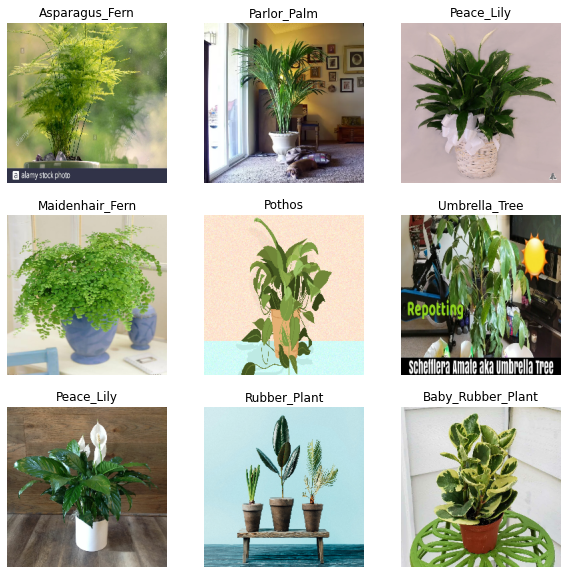

In [6]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

## Prefetch the data

In [7]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [8]:
# normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

In [9]:
# normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
# image_batch, labels_batch = next(iter(normalized_ds))
# first_image = image_batch[0]

# # Sanity check that the pixels values are now in `[0,1]`.
# print(np.min(first_image), np.max(first_image)) 

0.0005208969 0.92336607


# Build model

In [10]:
model = Sequential([
    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    
#     layers.Dense(128, activation='relu'),
#     layers.Dense(256, activation='relu'),
#     layers.Dense(128, activation='relu'),
#     layers.Conv2D(64, 3, padding='same', activation='relu'),
#     layers.Dense(64, activation='relu'),
#     layers.MaxPooling2D(),
    
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(no_classes),
    layers.Activation('softmax')
])

#   layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
#   layers.Conv2D(16, 3, padding='same', activation='relu'),
#   layers.MaxPooling2D(),
#   layers.Conv2D(32, 3, padding='same', activation='relu'),
#   layers.MaxPooling2D(),
#   layers.Conv2D(64, 3, padding='same', activation='relu'),
#   layers.MaxPooling2D(),
#   layers.Flatten(),
#   layers.Dense(128, activation='relu'),
#   layers.Dense(no_classes)

In [11]:
# IMG_SHAPE = (img_height, img_width, 3)

# resize_layer = layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3))

# # create the base model from the pre-trained model VGG16
# # note that, if using a Kaggle server, internet has to be turned on
# pretrained_model = tf.keras.applications.vgg16.VGG16(input_shape=IMG_SHAPE,
#                                                      include_top=False,
#                                                      weights='imagenet')

# # freeze the convolutional base
# pretrained_model.trainable = False

# model = tf.keras.Sequential([resize_layer,
#                              pretrained_model,
#                              GlobalAveragePooling2D(),
#                              Dense(256, activation='tanh'),
#                              Dense(256, activation='tanh'),
# #                              Dropout(0.5, name='drop_fc1'),
#                              Dense(no_classes, activation='softmax')])

In [12]:
# base_learning_rate = 0.01

# model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate), 
#               loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
#               metrics=['accuracy'])


# model.compile(optimizer='adam',
#               loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
#               metrics=['accuracy'])

model.compile(loss = 'sparse_categorical_crossentropy',
            optimizer = 'sgd',
            metrics = ['accuracy'])

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_1 (Rescaling)      (None, 240, 240, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 240, 240, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 120, 120, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 120, 120, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 60, 60, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 60, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 30, 30, 64)        0

# Train model

In [14]:
epochs=30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
80/80 [==============================] - 53s 662ms/step - loss: 2.7674 - accuracy: 0.0730 - val_loss: 2.7277 - val_accuracy: 0.1688
Epoch 2/30
80/80 [==============================] - 42s 530ms/step - loss: 2.7259 - accuracy: 0.1426 - val_loss: 2.7403 - val_accuracy: 0.1266
Epoch 3/30
80/80 [==============================] - 42s 530ms/step - loss: 2.6833 - accuracy: 0.1898 - val_loss: 2.7171 - val_accuracy: 0.1562
Epoch 4/30
80/80 [==============================] - 43s 531ms/step - loss: 2.6388 - accuracy: 0.2336 - val_loss: 2.5904 - val_accuracy: 0.2812
Epoch 5/30
80/80 [==============================] - 42s 530ms/step - loss: 2.5858 - accuracy: 0.2879 - val_loss: 2.5904 - val_accuracy: 0.2844
Epoch 6/30
80/80 [==============================] - 43s 534ms/step - loss: 2.5350 - accuracy: 0.3371 - val_loss: 2.5168 - val_accuracy: 0.3562
Epoch 7/30
80/80 [==============================] - 43s 533ms/step - loss: 2.4569 - accuracy: 0.4148 - val_loss: 2.4648 - val_accuracy: 0.4109

In [ ]:
base_learning_rate = 0.001

model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate), 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

epochs=10
history_2 = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10,8), sharex=True)

x_vals = np.arange(1, epochs+1)

ax[0].plot(x_vals, acc, '+-', label='training')
ax[0].plot(x_vals, val_acc, '+-', label='validation')
ax[0].legend()
ax[0].set_ylabel('accuracy')
ax[0].set_ylim(0, 1)
ax[0].grid(ls='--', c='C7')
ax[0].set_title('accuracy')

ax[1].plot(x_vals, loss, '+-', label='training')
ax[1].plot(x_vals, val_loss, '+-', label='validation')
ax[1].legend()
ax[1].set_ylabel('cross entropy')
ax[1].set_ylim(0, 1)
ax[1].grid(ls='--', c='C7')
ax[1].set_title('loss')
ax[1].set_xlabel('epoch')

plt.show()

In [ ]:
# freeze the convolutional base
model.trainable = False

tuned_model = tf.keras.Sequential([
                             model,
                             Dense(256, activation='tanh'),
                             Dense(no_classes, activation='softmax')])

In [ ]:
layers.Dense(no_classes, activation='softmax')

In [ ]:
import glob

pred_path = '../data/pred_16c_only1/'

pred_ds = tf.keras.preprocessing.image_dataset_from_directory(
    pred_path,
#     labels = [0]*len(glob.glob(f'{pred_path}*')),
    image_size=(img_height, img_width),
    batch_size=batch_size
    )

normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))

In [ ]:
predictions = model.predict(pred_ds)
print(predictions)

In [ ]:
# Generate arg maxes for predictions
classes = np.argmax(predictions, axis = 1)
print(classes[0])
print(class_names[classes[0]])